### 01h_standalone_konigsberg_bridge_example — A Classic Graph Theory Problem

### What this step does
This notebook is a standalone example demonstrating how a famous historical problem, the **Seven Bridges of Königsberg**, can be modeled and solved using graph theory with NetworkX. It abstracts the landmasses as nodes and the bridges as edges, then uses Eulerian path theory to determine if it's possible to traverse every bridge exactly once.

### Why this is useful
- Serves as a classic, intuitive introduction to graph theory concepts.
- Illustrates the power of abstracting real-world problems into graph structures.
- Demonstrates the use of a `MultiGraph` to model parallel edges (multiple bridges between the same landmasses).
- Introduces the concept of an **Eulerian Path** and how to check for one in NetworkX.

### Inputs
- None. This notebook is self-contained and generates its own graph structure.

### Outputs
- `outputs/01h_konigsberg_bridge/01h_konigsberg_bridge_visualisation.png`
- `outputs/01h_konigsberg_bridge/01h_analysis_summary.json`

### Key operations
- Model the Königsberg bridge problem using a `networkx.MultiGraph`.
- Calculate the degree of each node (landmass).
- Use `networkx.has_eulerian_path` to programmatically solve the problem.
- Explain the result based on the number of odd-degree nodes.
- Create a clear, labeled visualisation of the graph that represents the problem's geography.

In [3]:
# --- Step 0: Imports and Configuration ---
# 203 # This cell imports the necessary libraries for graph creation, analysis,
# 203 # and visualisation. It follows the established pattern of using a
# 203 # dataclass for configuration to ensure that all file paths are managed
# 203 # cleanly and relative to the project structure.

from __future__ import annotations

import json
from dataclasses import dataclass
from pathlib import Path

import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd

@dataclass(frozen=True)
class Config:
    """Configuration object for file paths and parameters."""
    output_dir: Path
    viz_file: Path
    summary_file: Path


def setup_config() -> Config:
    """Initialises configuration and creates necessary directories."""
    root_dir = Path(".")
    output_dir = root_dir / "outputs" / "01h_konigsberg_bridge"
    output_dir.mkdir(parents=True, exist_ok=True)

    return Config(
        output_dir=output_dir,
        viz_file=output_dir / "01h_konigsberg_bridge_visualisation.png",
        summary_file=output_dir / "01h_analysis_summary.json",
    )

cfg = setup_config()

print("--- Configuration Initialised ---")
print(f"Outputs will be saved to: {cfg.output_dir}")

--- Configuration Initialised ---
Outputs will be saved to: outputs/01h_konigsberg_bridge


In [4]:
# --- Step 1: Define and Build the Königsberg Graph ---
# 203 # This cell defines a single-purpose function to construct the graph.
# 203 # The problem involves multiple bridges connecting the same two landmasses,
# 203 # so a `MultiGraph` is the correct data structure to allow for these
# 203 # parallel edges. Nodes represent landmasses, and edges represent bridges.

def build_konigsberg_graph() -> nx.MultiGraph:
    """Creates the NetworkX MultiGraph representing the Königsberg bridges."""
    G = nx.MultiGraph()

    # 203 # Define the four landmasses as nodes.
    nodes = {
        "A": "North Bank",
        "B": "South Bank",
        "C": "Kneiphof Island",
        "D": "Lomse Island",
    }
    for node, name in nodes.items():
        G.add_node(node, name=name)

    # 203 # Define the seven bridges as edges between the landmasses.
    edges = [
        ("A", "C"), ("A", "C"),  # Two bridges between North Bank and Kneiphof Island
        ("A", "D"),             # One bridge between North Bank and Lomse Island
        ("B", "C"), ("B", "C"),  # Two bridges between South Bank and Kneiphof Island
        ("B", "D"),             # One bridge between South Bank and Lomse Island
        ("C", "D"),             # One bridge between the two islands
    ]
    G.add_edges_from(edges)

    print("Königsberg bridge problem modeled as a NetworkX MultiGraph.")
    print(f"- Nodes (Landmasses): {G.number_of_nodes()}")
    print(f"- Edges (Bridges): {G.number_of_edges()}")
    return G

# 203 # Execute the graph building function.
G_konigsberg = build_konigsberg_graph()

Königsberg bridge problem modeled as a NetworkX MultiGraph.
- Nodes (Landmasses): 4
- Edges (Bridges): 7


In [5]:
# --- Step 2: Analyze the Graph for an Eulerian Path ---
# 203 # This cell determines if an Eulerian path exists. According to Euler's theorem,
# 203 # a connected graph has an Eulerian path if and only if it has exactly zero or
# 203 # two nodes with an odd degree. We will calculate the degree of each node
# 203 # and then use the built-in NetworkX function to verify the result.

def analyze_eulerian_path(G: nx.MultiGraph) -> dict:
    """Analyzes node degrees to check for an Eulerian path."""
    # 203 # Calculate the degree (number of bridges) for each landmass.
    degrees = {node: G.degree(node) for node, data in G.nodes(data=True)}
    
    # 203 # Count how many nodes have an odd degree.
    odd_degree_nodes = [node for node, degree in degrees.items() if degree % 2 != 0]
    num_odd_degree = len(odd_degree_nodes)

    # 203 # Use NetworkX's built-in function to check for an Eulerian path.
    has_path = nx.has_eulerian_path(G)

    # 203 # Compile the results into a dictionary for analysis and export.
    analysis = {
        "node_degrees": degrees,
        "odd_degree_node_count": num_odd_degree,
        "odd_degree_nodes": odd_degree_nodes,
        "has_eulerian_path": has_path,
        "explanation": (
            "A path is possible (0 or 2 odd-degree nodes)."
            if has_path else
            f"No path is possible ({num_odd_degree} odd-degree nodes found; requires 0 or 2)."
        )
    }
    return analysis

# 203 # Run the analysis and print the results.
analysis_results = analyze_eulerian_path(G_konigsberg)

print("--- Eulerian Path Analysis ---")
print(pd.DataFrame.from_dict(analysis_results['node_degrees'], orient='index', columns=['Degree']).to_string())
print(f"\nNumber of odd-degree nodes: {analysis_results['odd_degree_node_count']}")
print(f"Has Eulerian Path? {analysis_results['has_eulerian_path']}")
print(f"Conclusion: {analysis_results['explanation']}")

--- Eulerian Path Analysis ---
   Degree
A       3
B       3
C       5
D       3

Number of odd-degree nodes: 4
Has Eulerian Path? False
Conclusion: No path is possible (4 odd-degree nodes found; requires 0 or 2).


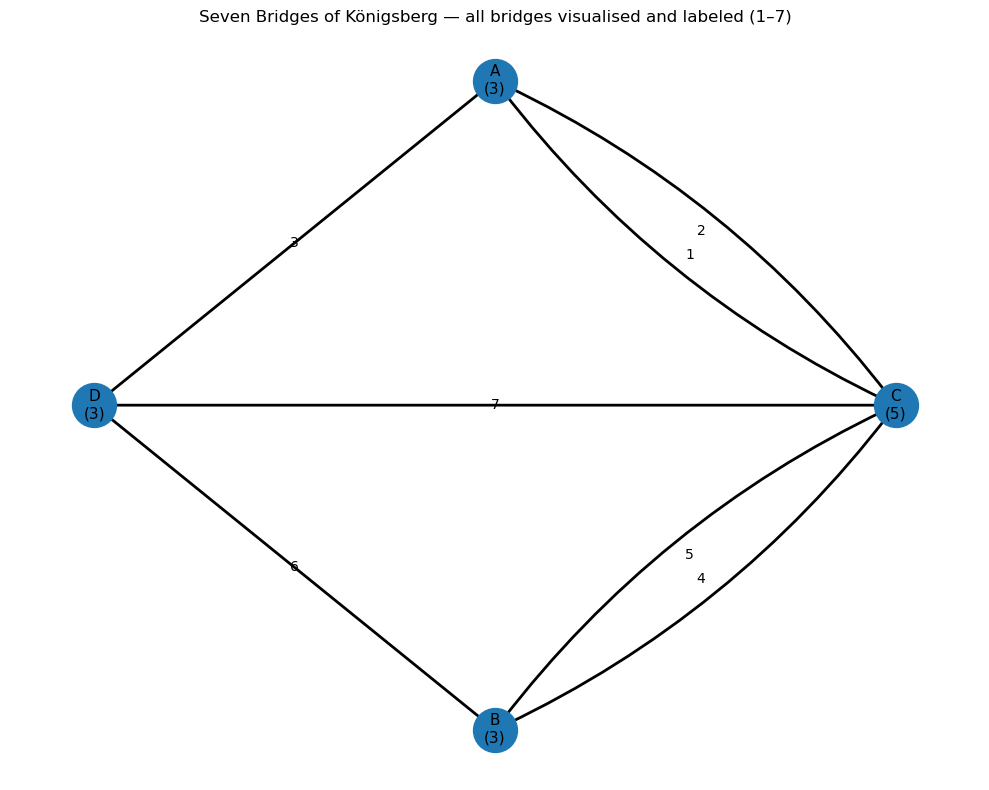

Saved to: outputs/01h_konigsberg_bridge/01h_konigsberg_bridges_labeled.png


In [6]:
# --- Step 3 (revised): Visualise *all* bridges with unique labels ---
from collections import defaultdict
import math

def visualize_all_bridges(G: nx.MultiGraph, file_path: Path, also_svg: bool = True) -> None:
    """Draws each parallel bridge with curvature and a numeric label (1–7)."""
    # Fixed geographic-style layout (as you had it)
    pos = {"A": (0, 2), "B": (0, 0), "C": (1.6, 1), "D": (-1.6, 1)}

    # Ensure each edge has a bridge_id (1..n)
    for i, (_, _, k, data) in enumerate(G.edges(keys=True, data=True), start=1):
        data.setdefault("bridge_id", i)

    # Compute curvature per unordered node pair so parallels don’t overlap
    pair_to_keys = defaultdict(list)
    for u, v, k in G.edges(keys=True):
        pair_to_keys[tuple(sorted((u, v)))].append(k)

    pair_to_rad = {}
    for pair, keys in pair_to_keys.items():
        n = len(keys)
        if n == 1:
            pair_to_rad[pair] = {keys[0]: 0.0}
        else:
            step = 0.25
            start = -step * (n - 1) / 2.0
            pair_to_rad[pair] = {k: (start + i * step) for i, k in enumerate(sorted(keys))}

    fig, ax = plt.subplots(figsize=(10, 8))

    # Nodes + labels (include degree)
    nx.draw_networkx_nodes(G, pos=pos, ax=ax, node_size=1000)
    node_labels = {n: f"{n}\n({G.degree(n)})" for n in G.nodes()}
    nx.draw_networkx_labels(G, pos=pos, labels=node_labels, ax=ax, font_size=11)

    def perp_offset(p0, p1, scale):
        x0, y0 = p0; x1, y1 = p1
        dx, dy = (x1 - x0), (y1 - y0)
        L = math.hypot(dx, dy) or 1.0
        # Perpendicular unit vector
        ux, uy = -dy / L, dx / L
        return (ux * scale, uy * scale)

    # Draw edges individually with curvature and manual labels
    for u, v, k, data in G.edges(keys=True, data=True):
        rad = pair_to_rad[tuple(sorted((u, v)))][k]
        nx.draw_networkx_edges(
            G, pos=pos, edgelist=[(u, v)], ax=ax,
            connectionstyle=f"arc3,rad={rad}", width=2.0
        )
        # Manual label near the curved edge
        p0, p1 = pos[u], pos[v]
        mid = ((p0[0] + p1[0]) / 2.0, (p0[1] + p1[1]) / 2.0)
        offx, offy = perp_offset(p0, p1, 0.35 * rad)
        ax.text(mid[0] + offx, mid[1] + offy, str(data["bridge_id"]),
                fontsize=10, ha="center", va="center")

    ax.set_title("Seven Bridges of Königsberg — all bridges visualised and labeled (1–7)")
    ax.axis("off")
    plt.tight_layout()
    fig.savefig(file_path, dpi=200)
    if also_svg:
        fig.savefig(file_path.with_suffix(".svg"))
    plt.show()

# Call it (add a second output alongside your existing png if you like)
out_png = cfg.output_dir / "01h_konigsberg_bridges_labeled.png"
visualize_all_bridges(G_konigsberg, out_png)
print(f"Saved to: {out_png}")


In [7]:
df_bridges = (
    pd.DataFrame([
        {"bridge_id": data.get("bridge_id"), "u": u, "v": v,
         "degree_u": G_konigsberg.degree(u), "degree_v": G_konigsberg.degree(v)}
        for u, v, k, data in G_konigsberg.edges(keys=True, data=True)
    ])
    .sort_values("bridge_id")
    .reset_index(drop=True)
)
display(df_bridges)
df_bridges.to_csv(cfg.output_dir / "01h_bridges.csv", index=False)


,bridge_id,u,v,degree_u,degree_v
0,1,A,C,3,5
1,2,A,C,3,5
2,3,A,D,3,3
3,4,B,C,3,5
4,5,B,C,3,5
5,6,B,D,3,3
6,7,C,D,5,3


In [8]:
# --- Step 4: Export Artifacts ---
# 203 # This final cell saves the analysis results to a JSON file. This creates a
# 203 # machine-readable record of the analysis, including the node degrees and the
# 203 # conclusion about the Eulerian path, completing the notebook's workflow.

def export_artifacts(analysis_results: dict, summary_path: Path):
    """Saves the analysis results to a JSON file."""
    with open(summary_path, 'w') as f:
        json.dump(analysis_results, f, indent=2)
    print(f"Analysis summary saved to {summary_path}")


# 203 # Execute the export function.
export_artifacts(analysis_results, cfg.summary_file)

print("\n--- Notebook 01h Complete ---")

Analysis summary saved to outputs/01h_konigsberg_bridge/01h_analysis_summary.json

--- Notebook 01h Complete ---


In [9]:
H = G_konigsberg.copy()
# remove any one bridge from an odd-degree node pair, e.g. one AC edge
u, v, k = next(iter([(u,v,k) for u,v,k in H.edges(keys=True) if set((u,v))=={"A","C"}]))
H.remove_edge(u, v, key=k)
import itertools
if nx.has_eulerian_path(H):
    trail = list(nx.eulerian_path(H))
    print("Eulerian path length:", len(trail))
    print("First 10 steps:", list(itertools.islice(trail, 10)))


Eulerian path length: 6
First 10 steps: [('B', 'C'), ('C', 'A'), ('A', 'D'), ('D', 'B'), ('B', 'C'), ('C', 'D')]


In [10]:
# --- Define the Königsberg graph so `G` exists ---

import networkx as nx


def build_konigsberg_graph() -> nx.MultiGraph:
    """
    Create the classic Königsberg MultiGraph with seven bridges.
    Nodes: A (North bank), B (South bank), C (Kneiphof), D (Lomse).
    Edges: two A–C, two B–C, one A–D, one B–D, one C–D.
    Each edge gets a unique bridge_id (1..7).
    """
    G = nx.MultiGraph()
    nodes = {
        "A": "North Bank",
        "B": "South Bank",
        "C": "Kneiphof Island",
        "D": "Lomse Island",
    }
    G.add_nodes_from((n, {"label": lbl}) for n, lbl in nodes.items())

    bridges = [
        ("A", "C"),
        ("A", "C"),
        ("B", "C"),
        ("B", "C"),
        ("A", "D"),
        ("B", "D"),
        ("C", "D"),
    ]
    for idx, (u, v) in enumerate(bridges, start=1):
        G.add_edge(u, v, key=idx, bridge_id=idx)

    return G


# Create the graph used elsewhere in the notebook
G = build_konigsberg_graph()


In [11]:
# Count odd-degree nodes (parity check)
odd = [n for n, d in G.degree() if d % 2]
print("Odd-degree nodes:", odd, "| count =", len(odd))


Odd-degree nodes: ['A', 'B', 'C', 'D'] | count = 4


In [12]:
# Make a near-miss Eulerian variant by removing one A–C bridge and try to find a trail
H = G.copy()
for u, v, k in H.edges(keys=True):
    if set((u, v)) == {"A", "C"}:
        H.remove_edge(u, v, key=k)
        break

import itertools
print("Has Eulerian path:", nx.has_eulerian_path(H))
if nx.has_eulerian_path(H):
    path = list(nx.eulerian_path(H))
    print("First few steps:", list(itertools.islice(path, 5)))


Has Eulerian path: True
First few steps: [('B', 'C'), ('C', 'A'), ('A', 'D'), ('D', 'B'), ('B', 'C')]


In [13]:
# Sanity checks
assert nx.is_connected(G.to_undirected()), "Graph must be connected"
deg_sum = sum(dict(G.degree()).values())
assert deg_sum == 2 * G.number_of_edges(), "Handshake lemma failed"


# Seven Bridges of Königsberg — concept & “code here” explainer

# What’s the core idea?

* The historic puzzle asks: **Can you walk through Königsberg crossing each of its seven bridges exactly once?**
* We model land masses as **nodes** (A, B, C, D) and bridges as **edges**. Because some pairs of places have **multiple bridges**, we need a **MultiGraph** (parallel edges allowed).
* **Euler’s rule**: An “exactly-once” walk (an Eulerian trail) is possible **iff** the graph is connected and it has **0 or 2 nodes of odd degree**. Königsberg has **4 odd-degree nodes**, so the original puzzle is impossible.

# What this notebook visualises (and why)

* **All seven bridges are explicitly drawn**, including the parallel ones, by adding a small **curvature** to each edge so they don’t overlap.
* Each bridge gets a **unique `bridge_id` (1–7)** printed near the curve—so you can literally count them and refer to them.
* Node labels include the **node degree** (number of bridges touching that node), which makes Euler’s condition **visible at a glance**.
* A small **bridge inventory table** lists every bridge, its endpoints, and the degrees at those endpoints—great for auditing and teaching.

# How the code works (step-by-step)

1. **Build a MultiGraph**

   * Nodes: `A, B, C, D` with human labels (North bank, South bank, Kneiphof, Lomse).
   * Edges: exactly seven entries, matching the historic map (two A–C, two B–C, one A–D, one B–D, one C–D).
   * Each edge stores a `bridge_id` so labels are stable and easy to read.

2. **Fixed “geographic-ish” layout**

   * Positions are set manually (small 2D coordinates) so the diagram **resembles the actual geometry** (banks left/right, island in the middle).

3. **Make parallel bridges visible**

   * For each unordered pair (e.g., A–C), the code groups all parallel edges and assigns **symmetric curvature** values (e.g., −0.25, +0.25).
   * This prevents lines from drawing on top of each other and makes *every* bridge distinct.

4. **Manual edge labels for MultiGraph**

   * NetworkX’s default edge labeling doesn’t support multiedges directly.
   * The notebook computes a **midpoint** between node positions and adds a **small perpendicular offset** proportional to the curvature, then places the bridge number (`bridge_id`) with `ax.text(...)`.
   * Result: labels sit near the correct arc, even when several arcs exist between the same nodes.

5. **Readable node labels**

   * Each node shows its name and **degree in parentheses** (e.g., `A (3)`), making the parity check (odd/even) transparent.

6. **Quality checks (recommended)**

   * Confirm the graph is connected.
   * Verify **sum of degrees = 2× number of edges**.
   * Count **odd-degree nodes** (Königsberg has four).
   * These asserts make the notebook robust and self-explanatory.

7. **Tidy outputs**

   * Save a **PNG** (quick sharing) and **SVG** (crisp print/zoom).
   * Export a **CSV** of the bridge inventory for reference or marking.

# Optional teaching demos (nice to add)

* **“Make it Eulerian”**: remove one bridge (or add one in the right place) and then call `nx.eulerian_path(H)` to show a valid route appears when there are 0 or 2 odd-degree nodes.
* **What changes parity?**: try toggling different bridges and re-checking the count of odd nodes—students see cause → effect.

# Why this explainer helps

* **Clarity**: curved multiedges + numeric labels eliminate ambiguity—every bridge is present and countable.
* **Pedagogy**: degree counts are visible on the diagram, making Euler’s test a **visual argument**.
* **Reusability**: the same pattern (MultiGraph + curvature + manual labels) generalises to any “islands & bridges” data.

# 2–3 ways to apply this pattern beyond Königsberg

* **Urban & trail planning**: model rivers, footbridges, and underpasses; ask “Can a sweeper or ranger traverse each link exactly once?” and identify **minimal link additions/removals** to enable it.
* **Network operations** (roads, utilities, data pipelines): map **parallel links** explicitly, audit odd-degree nodes, and plan **maintenance routes** that minimise repeats.
* **Teaching graph theory**: contrast **Eulerian (edges once)** vs **Hamiltonian (visit nodes once)**, show why they’re different problems, and give students hands-on parity experiments.

If you want, I can drop this explanation straight into your notebook as a Markdown cell and add the parity checks + “make it Eulerian” demo cells right after your visualisation.
